In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import os

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-3.1-8B-Instruct')

/data/miniforge3/envs/agent-planning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
saves = torch.load('../../data/TravelPlanner/attr_score/llama3.1-8B.pt')

/tmp/ipykernel_2485531/2587897438.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saves = torch.load('../../data/TravelPlanner/attr_score/llama3.1-8B.pt')


In [3]:
len(saves)

178

In [4]:
import json
def load_line_json_data(filename):
    data = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f.read().strip().split('\n'):
            unit = json.loads(line)
            data.append(unit)
    return data


In [6]:
from datasets import load_dataset

travel_data = load_dataset('osunlp/TravelPlanner','validation')['validation']

In [10]:
import re
model_name = 'llama3.1-8B'
ref_info_list = load_line_json_data(f"../../data/TravelPlanner/TravelPlanner_Items/{model_name}_attr_ref_info.jsonl")

def replace_placeholders_and_collect_pairs(input_string):
    # Define the regex pattern
    pattern = r'\[PLACEHOLDER \d+ \[(selected_[\w\d_]+)\] ([\d\w\s.,&/]+)\]'
    
    # Create a list to store the matched pair tuples
    pairs = []

    # Define the function for replacement
    def replace_placeholders(match):
        # Extract the matched content, keep the part starting with selected_ and the following value
        selected_item = match.group(1)
        value = match.group(2)
        # Add the pair tuple to the list
        pairs.append((selected_item, value))
        # Return {} to replace the PLACEHOLDER part
        return "{}"

    # Use re.sub() to perform the replacement and get the replaced string
    output_string = re.sub(pattern, replace_placeholders, input_string)

    # Return the replaced string and the recognized pair tuples
    return output_string, pairs

pairs_save = {}

for key in range(180):
    ref_info = ref_info_list[key]
    if ref_info:
        processed_ref_inf, pairs = replace_placeholders_and_collect_pairs(ref_info)
        pairs_save[key] = pairs
        if key not in saves:
            print(f"--{key}")
            pairs_save[key] = None
            continue
        if len(pairs)+1 != saves[key]['attr'].shape[-1]:
            pairs_save[key] = None
            print(key)
    else:
        pairs_save[key] = None

In [11]:
from tqdm import tqdm

def normalize(mean_tensors):
    # Calculate the maximum absolute value along the first dimension (row) of each tensor for normalization
    max_abs_vals, _ = torch.max(torch.abs(mean_tensors), dim=0, keepdim=True)
    
    # Normalize using the maximum absolute value, keep the original sign, and avoid division by zero
    normalized_tensors = torch.where(max_abs_vals == 0, mean_tensors, mean_tensors / max_abs_vals)

    return normalized_tensors

def obtain_token_and_attr(output_tokens, attr, start):
     
    index = start

    item_token = []
    item_attr = []

    while index < len(output_tokens)-2:
         
        if output_tokens[index] in ['[', "{'", "':", 'Ġ',"Ġ'","',",',',"'},","Ġ{'","':","Ġ'",  "Ġ'",'Ġ"']:
            index += 1
            continue

        if index + 3 < len(output_tokens) and tokenizer.convert_tokens_to_string([output_tokens[index],output_tokens[index+1],output_tokens[index+2],output_tokens[index+3]]).lower() == 'flight number: f':
            index+=4
            continue

        if output_tokens[index] in ["'},",'days']:
            break

        if tokenizer.convert_tokens_to_string([output_tokens[index],output_tokens[index+1]]).lower() in ['transportation','breakfast','attraction','lunch','dinner','accommodation','current_city']:
            break

        item_token.append(output_tokens[index])
        if torch.any(torch.abs(attr[index]) > 0):
            item_attr.append(attr[index])

        index += 1
    
    if len(item_attr) > 0:
        return tokenizer.convert_tokens_to_string(item_token), torch.sum(torch.stack(item_attr),dim=0)
    else:
        return None, None

data = []

for key in tqdm(range(180)):
    items = []
    if pairs_save[key] and key in saves:

        output_tokens = saves[key]['output_tokens']
        token_attr = saves[key]['attr']

        for idx, output_token in enumerate(saves[key]['output_tokens']):
            
            if output_token == 'transport' and saves[key]['output_tokens'][idx+1]== 'ation':
                token, attr = obtain_token_and_attr(output_tokens,token_attr,idx+2)
                items.append(('transportation',token,attr))
            
            elif output_token == 'break' and saves[key]['output_tokens'][idx+1]== 'fast':
                token, attr = obtain_token_and_attr(output_tokens,token_attr,idx+2)
                items.append(('breakfast',token,attr))

            elif output_token == 'attr' and saves[key]['output_tokens'][idx+1]== 'action':
                token, attr = obtain_token_and_attr(output_tokens,token_attr,idx+2)
                items.append(('attraction',token,attr))

            elif output_token == 'l' and saves[key]['output_tokens'][idx+1]== 'unch':
                token, attr = obtain_token_and_attr(output_tokens,token_attr,idx+2)
                items.append(('lunch',token,attr))

            elif output_token == 'd' and saves[key]['output_tokens'][idx+1]== 'inner':
                token, attr = obtain_token_and_attr(output_tokens,token_attr,idx+2)
                items.append(('dinner',token,attr))
            
            elif output_token == 'accom' and saves[key]['output_tokens'][idx+1]== 'modation':
                token, attr = obtain_token_and_attr(output_tokens,token_attr,idx+2)
                items.append(('accommodation',token,attr))
    data.append(items)


  0%|          | 0/180 [00:00<?, ?it/s]

100%|██████████| 180/180 [00:02<00:00, 76.09it/s]


In [19]:
outputs = []

for index,instance in enumerate(data):
    if instance == []:
        outputs.append(None)
        continue
    packages = []
    current_package = []
    # Set a flag, package from 'transportation' to 'accommodation'
    for entry in instance:
        label = entry[0]
        
        # if label == 'attraction':
        #     continue

        # If 'transportation' is encountered, start a new package
        if label == 'transportation' and current_package:
            current_package = []
        # Add each entry to the current package

        if entry[1] and "'-'" not in entry[1] :
        # if entry[1]:
           
            current_package.append(entry)

        # If 'accommodation' is encountered, finish the package and add it to the packages list
        if label == 'accommodation':
            packages.append(current_package)


    outputs.append(packages[:7])

print(outputs[0])
question_attr = {idx:[] for idx in range(1,8)}
insight_attr = []

for instance in tqdm(outputs[:]):
    if instance:
        insight = []
        for idx, item in enumerate(instance):
            # print(item)
            item = [x[2] for x in item ]
            insight= [x[0] for x in item]
            # print(insight)
            questions = [x[-1] for x in item ]
            if len(questions) > 0:
                question_mean_attr = torch.mean(torch.stack(questions))
                question_attr[idx+1].append(question_mean_attr)
                insight_mean_attr = torch.sum(torch.stack(insight))
                insight_attr.append(insight_mean_attr)

for key in question_attr:
    day_attr = torch.mean(torch.stack(question_attr[key]))

    if key in [1,3,5,7]:
        print(f"({key}, {day_attr.item()})")


[[('transportation', '3927581 from Washington to Myrtle Beach Departure Time:11:03 Arrival Time:13:31', tensor([0.1210, 0.5906], device='cuda:0')), ('dinner', 'Dunkin\' Donuts Myrtle Beach",', tensor([-0.1524,  0.0996], device='cuda:0')), ('accommodation', 'Kharkovy Cottage & Hotel Myrtle Beach', tensor([ 0.2461, -1.8233], device='cuda:0'))], [('breakfast', 'Subway Myrtle Beach', tensor([-0.0355,  0.2059], device='cuda:0')), ('attraction', 'Broadway at the Beach Myrtle Beach;Myrtle Beach State Park Myrtle Beach;Ripley\'s Aquarium of Myrtle Beach Myrtle Beach;",', tensor([-0.0436, -0.1040], device='cuda:0')), ('lunch', 'Eat Street Express Myrtle Beach', tensor([ 0.4019, -0.2580], device='cuda:0')), ('dinner', 'Eat Street Express Myrtle Beach', tensor([ 0.4138, -0.8159], device='cuda:0')), ('accommodation', 'Kharkovy Cottage & Hotel Myrtle Beach', tensor([0.0019, 0.0351], device='cuda:0'))], [('transportation', '3926434 from Myrtle Beach to Washington Departure Time:13:45 Arrival Time:15

100%|██████████| 180/180 [00:00<00:00, 4395.44it/s]

(1, 0.06346722692251205)
(3, -0.008866379968822002)
(5, 0.024129832163453102)
(7, 0.055365052074193954)


In [13]:
from typing import Union, Tuple
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plot_token_attr(
    token_attr, input_tokens, output_tokens, show: bool = True
) -> Union[None, Tuple[plt.Figure, plt.Axes]]:
    """
    Generate a matplotlib plot for visualizing the attribution of output tokens.

    Args:
        token_attr (torch.Tensor): The tensor containing token attributions.
        input_tokens (List[str]): List of input tokens used as x-axis labels.
        output_tokens (List[str]): List of output tokens used as y-axis labels.
        show (bool, optional): Whether to display the plot immediately or return the figure and axis.
            Default: True.

    Returns:
        Union[None, Tuple[plt.Figure, plt.Axes]]: None if `show` is True, otherwise returns the figure and axes.
    """
    if token_attr is None:
        raise ValueError(
            "token_attr is None (no token-level attribution was performed). Please use plot_seq_attr "
            "instead for the sequence-level attribution plot."
        )

    # Ensure the token_attr is on the CPU
    token_attr = token_attr.cpu()

    # Convert token_attr to a NumPy array for visualization
    data = token_attr.numpy()

    # Define a custom colormap with the specified positive and negative colors
    positive_color = (102 / 255, 194 / 255, 165 / 255)  # RGB normalized to 0-1 range
    negative_color = (251 / 255, 84 / 255, 56 / 255)   # RGB normalized to 0-1 range
    zero_color = (1, 1, 1)  # White for neutral (zero) values

    # Create the custom colormap using LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list(
        "custom_cmap",
        [negative_color, zero_color, positive_color],
        N=256
    )

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(max(data.shape[1] * 1.3, 6.4), max(data.shape[0] / 2.5, 4.8)))

    # Plot the heatmap with the custom colormap and normalized color range centered around zero
    im = ax.imshow(data, cmap=cmap, vmin=-1, vmax=1, aspect=0.5)

    # Create a colorbar with a label
    cbar = fig.colorbar(im, ax=ax, fraction=0.024, pad=0.04) 
    cbar.ax.set_ylabel("Attribution Score", rotation=-90, va="bottom", fontsize=15)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Set tick labels for x and y axes
    ax.set_xticks(np.arange(data.shape[1]), labels=input_tokens)
    ax.set_yticks(np.arange(data.shape[0]), labels=output_tokens)

    # Move the x-axis labels to the top
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate x-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")
    # plt.setp(ax.get_xticklabels(), rotation=0, rotation_mode="anchor")

    # Add text annotations on each cell with color contrast adjustment
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data[i, j]
            color = "black" if 0.2 < im.norm(val) < 0.8 else "white"
            ax.text(
                j, i, f"{val:.4f}",
                ha="center", va="center", color=color
            )

    # Show the plot or return the figure and axis based on the `show` flag
    if show:
        plt.show()
        return None
    else:
        return fig, ax

In [23]:
constraint_dict = {x:{y:[] for y in ['transportation','restaurant','accommodation','attraction']} for x in ['selected_cost_item', 'selected_minimum_nights_item', 'selected_house_rules_item', 'selected_room_type_item','selected_cuisine_item']}

for idx, instance in tqdm(enumerate(outputs)):
    if pairs_save[idx] is None or instance is None:
        continue
    constraint_pairs = pairs_save[idx]

    feature_n = len(constraint_pairs) + 1
    
    for pos, item in enumerate(constraint_pairs):
        feature = item[0]
        values = []
        if feature == 'selected_cost_item':
            for unit in instance:
                for entry in unit:
                    label = entry[0]
                    if label in ['breakfast','lunch','dinner']:
                        label = 'restaurant'
                    if "'-" not in entry[1]:
                        constraint_dict[feature][label].append(entry[2][pos])
        elif feature == 'selected_minimum_nights_item':
            for unit in instance:
                for entry in unit:
                    label = entry[0]
                    if label in ['breakfast','lunch','dinner']:
                        label = 'restaurant'
                    if "'-" not in entry[1]:
                        constraint_dict[feature][label].append(entry[2][pos])
        elif feature == 'selected_house_rules_item':
            for unit in instance:
                for entry in unit:
                    label = entry[0]
                    if label in ['breakfast','lunch','dinner']:
                        label = 'restaurant'
                    if "'-" not in entry[1]:
                        constraint_dict[feature][label].append(entry[2][pos])
        elif feature == 'selected_cuisine_item':
            for unit in instance:
                for entry in unit:
                    label = entry[0]
                    if label in ['breakfast','lunch','dinner']:
                        label = 'restaurant'
                    if "'-" not in entry[1]:
                        constraint_dict[feature][label].append(entry[2][pos])
        elif feature == 'selected_room_type_item':
            for unit in instance:
                for entry in unit:
                    label = entry[0]
                    if label in ['breakfast','lunch','dinner']:
                        label = 'restaurant'
                    if "'-" not in entry[1]:
                        constraint_dict[feature][label].append(entry[2][pos])

180it [00:00, 9331.85it/s]


torch.Size([4, 5])


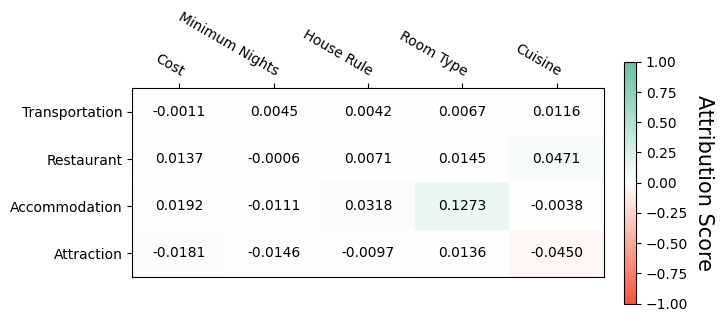

In [25]:
from copy import deepcopy
transportation = torch.stack([torch.mean(torch.stack(constraint_dict[x]['transportation']),dim=0) for x in constraint_dict])

restaurant = torch.stack([torch.mean(torch.stack(constraint_dict[x]['restaurant']),dim=0) for x in constraint_dict])
accommodation = torch.stack([torch.mean(torch.stack(constraint_dict[x]['accommodation']),dim=0) for x in constraint_dict])
attraction = torch.stack([torch.mean(torch.stack(constraint_dict[x]['attraction']),dim=0) for x in constraint_dict])
transportation = transportation.unsqueeze(1)
restaurant = restaurant.unsqueeze(1)
accommodation = accommodation.unsqueeze(1)
attraction = attraction.unsqueeze(1)

# Now stack them together
new_values = torch.cat([ transportation,restaurant,accommodation,attraction], dim=1)
new_values = new_values.transpose(0, 1)

print(new_values.shape)
fig, ax = plot_token_attr(new_values,['Cost','Minimum Nights','House Rule','Room Type','Cuisine'],['Transportation','Restaurant','Accommodation','Attraction'],False)